### Data to be used: Amazon_fine_food_reviews.csv

### Problem statement: Use the data from"Summary" and "text" column of the above file. Ignore the other columns. Perform a clustering on the data after finding the optimum number of clusters. On found out clusters perform the topic modelling.i.e. if you have found 10 clusters then there should be 10 topics as well.

Import packages and libraries

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats 
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Import Data

In [28]:
amazon= pd.read_csv("/Amazon_fine_food_reviews.csv")

In [29]:
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


PreProcessing of data

In [30]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199141 entries, 0 to 199140
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      199141 non-null  int64 
 1   ProductId               199141 non-null  object
 2   UserId                  199141 non-null  object
 3   ProfileName             199133 non-null  object
 4   HelpfulnessNumerator    199141 non-null  int64 
 5   HelpfulnessDenominator  199141 non-null  int64 
 6   Score                   199141 non-null  int64 
 7   Time                    199141 non-null  int64 
 8   Summary                 199133 non-null  object
 9   Text                    199141 non-null  object
dtypes: int64(5), object(5)
memory usage: 15.2+ MB


In [74]:
reindexed_data = amazon['Text']

In [75]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

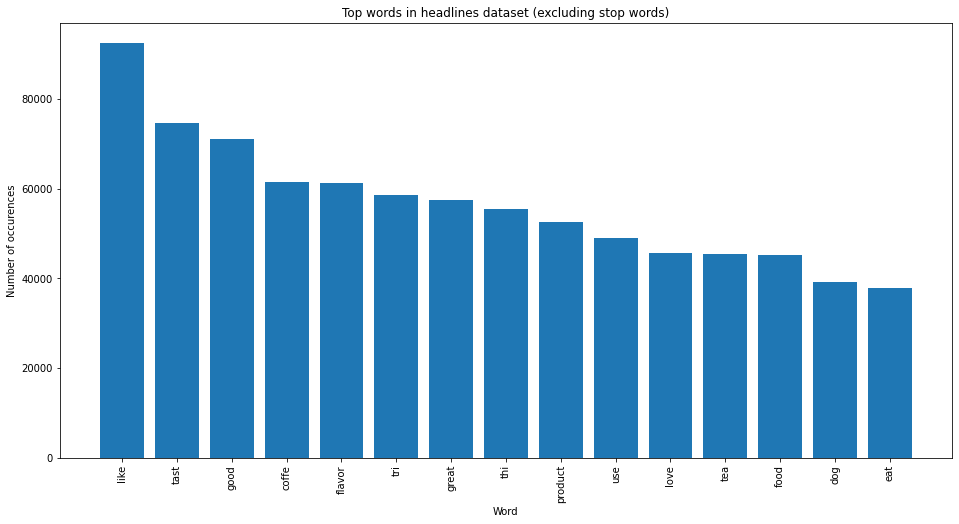

In [76]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [84]:
import nltk
nltk.download('averaged_perceptron_tagger')
tagged_reviews = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [87]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_reviews})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  6547269
Mean number of words per headline:  32.87755409483733


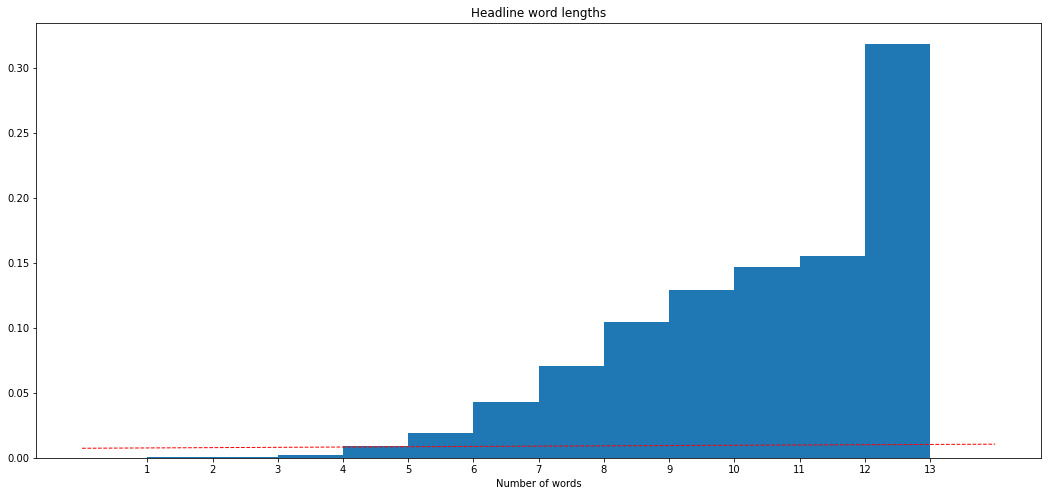

In [88]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()


In [59]:
reindexed_data = amazon['Text']

In [60]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [19]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('words')
nltk.download('stopwords')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
reindexed_data

0        I have bought several of the Vitality canned d...
1        Product arrived labeled as Jumbo Salted Peanut...
2        This is a confection that has been around a fe...
3        If you are looking for the secret ingredient i...
4        Great taffy at a great price.  There was a wid...
                               ...                        
29936    This soup mix makes a tasty addition to any mu...
29937    If you lack dark green vegetables this will su...
29938    I love my coffee and have tried all the name b...
29939    Folgers classic roast has been my trusted bran...
29940                                                  NaN
Name: Text, Length: 29941, dtype: object

In [21]:
eng_words = set(nltk.corpus.words.words())

In [32]:
def preprocessing(in_amazon):
    #tokenization
    in_amazon['Text'] = in_amazon['Text'].apply(lambda x: x.split())
    print("After tokenisation")
    print(in_amazon.head())

    punctuations = string.punctuation
    print(f"The punctuations are {punctuations}")


    #remove punctuations
    in_amazon['Text'] = in_amazon['Text'].apply(lambda x: [word.strip(punctuations) for word in x])
    print("After removing punctuations")
    print(in_amazon.head())

    #remove numbers
    amazon['Text'] = amazon['Text'].apply(lambda x: [word for word in x if not word.isdigit()])
    print("After removing digits")
    print(amazon.head())
    
    #remove non english words
    amazon['Text'] = amazon['Text'].apply(lambda x: [word for word in x if word.lower() in eng_words])
    print("After removing digits")
    print(amazon.head())

    #remove worls smaller than length 3
    amazon['Text'] = amazon['Text'].apply(lambda x: [word for word in x if len(word) > 2])
    print("After removing digits")
    print(amazon.head())

    #stop word removal
    stop_words = stopwords.words('english')
    in_amazon['Text'] = in_amazon['Text'].apply(lambda x: [word for word in x if word not in stop_words])
    print("After removing stop words")
    print(in_amazon.head())

    

    #stemming
    ps = PorterStemmer() 
    in_amazon['Text'] = in_amazon['Text'].apply(lambda x: [ ps.stem(word) for word in x])
    print("After removing stop words")
    print(in_amazon.head())


    # join tokens back
    in_amazon['Text'] = in_amazon['Text'].apply(lambda x: " ".join(x))
    print("After joining the tokens back")
    print(in_amazon.head())
    return in_amazon


processed_amazon = preprocessing(amazon)
#get the corpus in the form of list of strings
corpus_text = list(amazon['Text'].values)


    

After tokenisation
   Id  ...                                               Text
0   1  ...  [I, have, bought, several, of, the, Vitality, ...
1   2  ...  [Product, arrived, labeled, as, Jumbo, Salted,...
2   3  ...  [This, is, a, confection, that, has, been, aro...
3   4  ...  [If, you, are, looking, for, the, secret, ingr...
4   5  ...  [Great, taffy, at, a, great, price., There, wa...

[5 rows x 10 columns]
The punctuations are !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
After removing punctuations
   Id  ...                                               Text
0   1  ...  [I, have, bought, several, of, the, Vitality, ...
1   2  ...  [Product, arrived, labeled, as, Jumbo, Salted,...
2   3  ...  [This, is, a, confection, that, has, been, aro...
3   4  ...  [If, you, are, looking, for, the, secret, ingr...
4   5  ...  [Great, taffy, at, a, great, price, There, was...

[5 rows x 10 columns]
After removing digits
   Id  ...                                               Text
0   1  ...  [I, have, bou

In [33]:
len(corpus_text)

199141

In [34]:
type(corpus_text)

list

In [35]:
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime

In [36]:
tf_vectorizer = CountVectorizer(stop_words='english')
tf_vectorizer.fit(corpus_text)
tf = tf_vectorizer.transform(corpus_text)
tf_feature_names = tf_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
tf_feature_names[-10:]

['zone',
 'zoo',
 'zoolog',
 'zoom',
 'zoonot',
 'zooplankton',
 'zorro',
 'zowi',
 'zucchini',
 'zwieback']

In [38]:
no_topics = 10
t1 = datetime.now()
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online',\
                                learning_offset=50.,random_state=0)
lda.fit(tf)
t2 = datetime.now()

print(f"Total time taken for fitting  is {t2-t1}")

Total time taken for fitting  is 0:06:41.498373


Topic modelling

In [39]:
for topic_id, topic in enumerate(lda.components_):
    print(topic_id)
    print(topic)
    #print(len(topic))
    topic_keywords = [tf_feature_names[i] for i in topic.argsort()[-10:]]
    print(topic_keywords)
    keyword_weights = sorted(topic)[-10:]
    keyword_weights = [round(weight, 2) for weight in keyword_weights]
    print(keyword_weights)
    print("-"*50)

0
[0.10001085 0.10015511 0.10014612 ... 0.10000316 0.10005087 0.1000339 ]
['feed', 'day', 'tri', 'dri', 'treat', 'like', 'cat', 'eat', 'dog', 'food']
[7405.86, 8074.71, 8216.21, 8244.86, 8678.01, 10834.64, 13714.43, 19388.04, 37667.95, 47241.76]
--------------------------------------------------
1
[ 0.10001955  0.10004691  0.10000002 ...  0.1         0.10001753
 18.859074  ]
['descript', 'stale', 'rememb', 'jar', 'date', 'choic', 'popcorn', 'peanut', 'disappoint', 'butter']
[1878.38, 1996.17, 2051.79, 2076.84, 2586.36, 3129.21, 4729.46, 5977.13, 7489.56, 8148.62]
--------------------------------------------------
2
[ 0.10002912  0.10003849  0.10281289 ...  0.10001701 43.04925852
  0.10001742]
['better', 'littl', 'think', 'sweet', 'realli', 'good', 'tri', 'flavor', 'tast', 'like']
[11101.02, 11479.79, 11990.3, 15277.45, 19494.92, 23496.87, 26533.38, 35930.57, 47506.47, 52065.8]
--------------------------------------------------
3
[ 0.10001748  0.10005914  0.10153083 ...  0.1000024  20.8

In [44]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_document_term_matrix = small_count_vectorizer.fit_transform(corpus_text)

print('review after vectorization: \n{}'.format(small_document_term_matrix[123]))

review after vectorization: 
  (0, 12129)	1
  (0, 5164)	4
  (0, 5746)	2
  (0, 10795)	3
  (0, 11057)	1
  (0, 7888)	1
  (0, 4244)	2
  (0, 14282)	1
  (0, 4099)	4
  (0, 13208)	1
  (0, 130)	1
  (0, 379)	1
  (0, 7761)	1
  (0, 15127)	1
  (0, 9233)	1
  (0, 1083)	1
  (0, 9573)	1
  (0, 7848)	1
  (0, 9157)	1
  (0, 15880)	2
  (0, 9948)	1
  (0, 9250)	2
  (0, 4855)	1
  (0, 11030)	1
  (0, 11271)	1
  (0, 2080)	1
  (0, 4868)	1
  (0, 6415)	3
  (0, 12045)	2
  (0, 1108)	1
  (0, 4275)	1
  (0, 15722)	1
  (0, 10451)	1
  (0, 8147)	1


In [46]:
lda_topic_matrix = lda.fit_transform(small_document_term_matrix)

In [49]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [51]:
from collections import Counter
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [63]:
n_topics = 10

In [64]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  dog food eat like cat tri good love product time
Topic 2:  popcorn butter peanut like tast popper thi movi good product
Topic 3:  like tast flavor good tri realli thi tea coffe drink
Topic 4:  great price product good thi love buy store order like
Topic 5:  order product time good like box receiv thi ship great
Topic 6:  use bag like box product time coffe work good littl
Topic 7:  product use like tast thi good sugar magnesium tri food
Topic 8:  coffe tea flavor like cup tast thi good drink tri
Topic 9:  chocol great tast good use like make thi love mix
Topic 10:  chip like flavor tast good great use salt oil thi


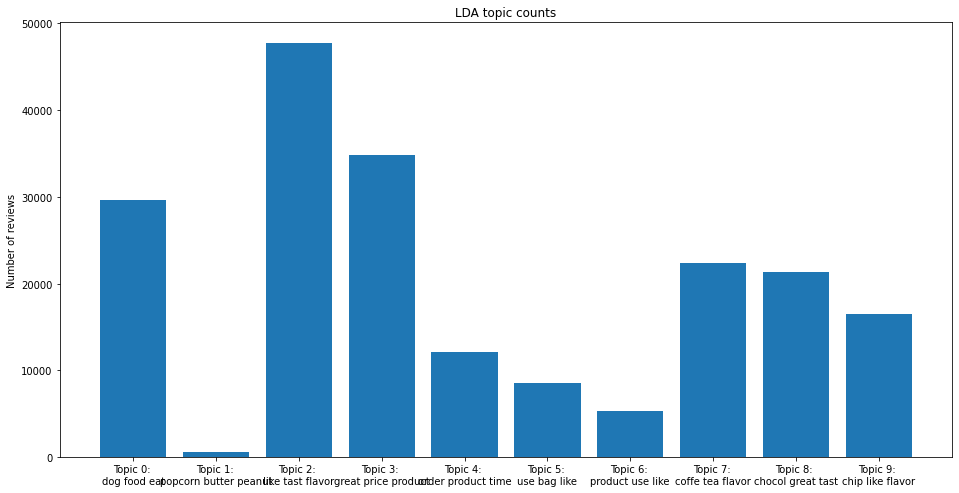

In [67]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of reviews');
ax.set_title('LDA topic counts');
plt.show()

Distribution of maximum occured keywords from 10 topics

Clustering of topics

In [69]:
from sklearn.manifold import TSNE

In [73]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 199141 samples in 0.512s...
[t-SNE] Computed neighbors for 199141 samples in 121.268s...
[t-SNE] Computed conditional probabilities for sample 1000 / 199141
[t-SNE] Computed conditional probabilities for sample 2000 / 199141
[t-SNE] Computed conditional probabilities for sample 3000 / 199141
[t-SNE] Computed conditional probabilities for sample 4000 / 199141
[t-SNE] Computed conditional probabilities for sample 5000 / 199141
[t-SNE] Computed conditional probabilities for sample 6000 / 199141
[t-SNE] Computed conditional probabilities for sample 7000 / 199141
[t-SNE] Computed conditional probabilities for sample 8000 / 199141
[t-SNE] Computed conditional probabilities for sample 9000 / 199141
[t-SNE] Computed conditional probabilities for sample 10000 / 199141
[t-SNE] Computed conditional probabilities for sample 11000 / 199141
[t-SNE] Computed conditional probabilities for sample 12000 / 199141
[t-SNE] Computed conditional prob

KeyboardInterrupt: ignored

In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [72]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

NameError: ignored